# Testing software

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import pystan

## Sources

Decided to go with the astromodels package as python3 branch is working well.

To install: 
```
pip install git+https://github.com/giacomov/astromodels.git@py2to3
```

In [2]:
from source.source import *
from astromodels.functions.functions import Powerlaw
from astromodels import Model

In [3]:
# Single source
source = PointSource('point', ra=123, dec=-30, redshift=0.1, unit_vector = [1, 0, 0], spectral_shape=Powerlaw())
source.position.get_ra()
source.redshift

0.1

In [4]:
# Loading from file
source_file = '../dev/statistical_model/data/test_SFR_pop.h5'
source_list = TestSourceList(source_file, spectral_shape=Powerlaw())

# Select sources below zth = 1
zth = 1.0
source_list.select_below_redshift(zth)

# Add a diffuse background at z = 1
diffuse_bg = DiffuseSource('diffuse_bg', zth, spectral_shape=Powerlaw())
source_list.add(diffuse_bg)

In [5]:
source_list.sources[9].redshift

0.5660079309384869

In [6]:
source_list.sources[0].unit_vector

array([-0.01066771, -0.00631701, -0.00437524])

In [7]:
# Could also use an astromodels model
source_model = Model(*source_list.sources)

## Precomputation

In [8]:
from Precomputation import ExposureIntegral
from detector_model import NorthernTracksEffectiveArea

In [9]:
time = 8 # years
Emin = 1.0e5 # GeV

exposure_integral = ExposureIntegral(source_list, NorthernTracksEffectiveArea, 
                                     time, Emin)
exposure_integral()

INFO:backend.code_generator:Object of type <backend.stan_generator.FunctionsContext object at 0x11bd81e90> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.DefinitionContext object at 0x11bd40e10> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.DefinitionContext object at 0x11bd92390> already on stack


/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


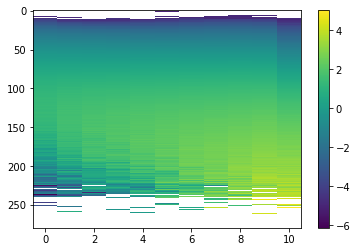

In [10]:
fig, ax = plt.subplots()
plt.imshow(np.log10(exposure_integral._effective_area._eff_area), aspect='auto')
plt.colorbar()

In [11]:
np.shape(exposure_integral._effective_area._eff_area)
exposure_integral._effective_area._cosz_bin_edges

array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
        0.1])

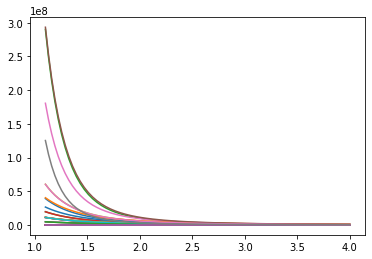

In [12]:
fig, ax = plt.subplots()
for _ in exposure_integral.integral_grid:
    ax.plot(exposure_integral.alpha_grid, _)

## Generate Stan code for simulation


In [13]:
from detector_model import NorthernTracksDetectorModel
from backend.stan_generator import (
    StanGenerator, GeneratedQuantitiesContext, DataContext, TransformedDataContext,
    FunctionsContext, Include, ForLoopContext, StanFileGenerator)
from backend.variable_definitions import ForwardVariableDef, ForwardArrayDef
from backend.expression import StringExpression
from backend.parameterizations import DistributionMode
import logging
logging.basicConfig(level=logging.WARN)

In [14]:
with StanFileGenerator("stan_files/detector_model_test") as cg:   
    ntd_rng = NorthernTracksDetectorModel(mode=DistributionMode.RNG)
    ntd_pdf = NorthernTracksDetectorModel(mode=DistributionMode.PDF) 
    cg.generate_files()

INFO:backend.code_generator:Object of type <backend.stan_generator.FunctionsContext object at 0x116d7db50> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.FunctionsContext object at 0x116d74350> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.DefinitionContext object at 0x116d518d0> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.DefinitionContext object at 0x116d51290> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.DefinitionContext object at 0x116d51b10> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.DefinitionContext object at 0x116d51950> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.FunctionsContext object at 0x116d740d0> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.FunctionsContext object at 0x116d51c50> already on stack
INFO

In [94]:
with StanGenerator() as cg:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")
        _ = Include("interpolation.stan")
        _ = Include("sim_functions.stan")
        _ = Include("energy_spectrum.stan")
        ntd = NorthernTracksDetectorModel()
            
    with DataContext() as dc:
        
        # Sources
        Ns = ForwardVariableDef("Ns", "int")
        Ns_str = ["[", Ns, "]"]
        Ns_1p_str = ["[", Ns, "+1]"]
        
        varpi = ForwardArrayDef("varpi", "unit_vector[3]", Ns_str)
        D = ForwardVariableDef("D", "vector[Ns]")
        redshift = ForwardVariableDef("z", "vector[Ns+1]")
        
        # Energies
        alpha = ForwardVariableDef("alpha", "real")
        Emin = ForwardVariableDef("Emin", "real")
        
        # Flux
        Q = ForwardVariableDef("Q", "real")
        F0 = ForwardVariableDef("F0", "real")
        
        # Precomputed quantities
        Ngrid = ForwardVariableDef("Ngrid", "int")
        Ngrid_str = ["[", Ngrid, "]"]
        alpha_grid = ForwardVariableDef("alpha_grid", "vector[Ngrid]")
        integral_grid = ForwardArrayDef("integral_grid", 
                                        "vector[Ngrid]", Ns_1p_str)
        aeff_max = ForwardVariableDef("aeff_max", "real")
        
        # Inputs
        T = ForwardVariableDef("T", "real")
        
    with TransformedDataContext() as tdc:
        F = ForwardVariableDef("F", "vector[Ns+1]")
        FT = ForwardVariableDef("FT", "real")
        Fs = ForwardVariableDef("Fs", "real")
        f = ForwardVariableDef("f", "real")
        w_exposure = ForwardVariableDef("w_exposure", "simplex[Ns+1]")
        Nex = ForwardVariableDef("Nex", "real")
        N = ForwardVariableDef("N", "int")
        eps = ForwardVariableDef("eps", "vector[Ns+1]")
        
        #Mpc_to_m = ForwardVariableDef("Mpc_to_m", "real")
        #Mpc_to_m << StringExpression("3.086e22")
        
        with ForLoopContext(1, Ns, "k") as k:
            F[k] << StringExpression([Q, "/ (4 * pi() * pow(", 
                                         D[k], " * ", 3.086e22, ", 2))"])
            StringExpression([Fs," += ", F[k]])
        
        StringExpression("F[Ns+1]") << F0
        
        FT << Fs + FT
        f << StringExpression([Fs, "/", FT])
        
        eps << StringExpression(["get_exposure_factor(", T, ", ", Emin, ", ", alpha, 
                                 ", ", alpha_grid, ", ", integral_grid, ", ", Ns, ")"])
        Nex << StringExpression(["get_Nex_sim(", F, ", ", eps, ")"])
        w_exposure << StringExpression(["get_exposure_weights(", F, ", ", 
                                              eps, ")"])
        N << StringExpression(["poisson_rng(", Nex, ")"])
        StringExpression(["print(", w_exposure, ")"])
        StringExpression(["print(", Ngrid, ")"])
        StringExpression(["print(", Nex, ")"])
        StringExpression(["print(", N, ")"])
        
    with GeneratedQuantitiesContext() as gqc:
        ntd_rng = NorthernTracksDetectorModel(mode=DistributionMode.RNG)
        ntd_pdf = NorthernTracksDetectorModel(mode=DistributionMode.PDF) 
        
        N_str = ["[", N, "]"]
        lam = ForwardArrayDef("Lambda", "int", N_str)
        omega = ForwardVariableDef("omega", "unit_vector[3]")
        
        Esrc = ForwardVariableDef("Esrc", "vector[N]")
        E = ForwardVariableDef("E", "vector[N]")
        Edet = ForwardVariableDef("Edet", "vector[N]")
        
        cosz = ForwardArrayDef("cosz", "real", N_str)
        Pdet = ForwardArrayDef("Pdet", "real", N_str)
        accept = ForwardVariableDef("accept", "int")
        ntrials = ForwardVariableDef("ntrials", "int")
        prob = ForwardVariableDef("prob", "simplex[2]")
        
        event = ForwardArrayDef("event", "unit_vector[3]", N_str)
        Nex_sim = ForwardVariableDef("Nex_sim", "real")
        
        Nex_sim << Nex

        with ForLoopContext(1, N, "i") as i:
            
            lam[i] << StringExpression(["categorical_rng(", w_exposure,")"])
            
            accept << 0
            ntrials << 0
            StringExpression(["while(", accept, " != 1) {\n", 
                              #lam[i], " = categorical_rng(", w_exposure, ");\n",
                              "if (", lam[i], " < Ns+1) {\n",
                              omega, " = ", varpi[lam[i]], ";\n",
                              #omega, " = sphere_rng(1);\n"
                              "}\n", "else if (", lam[i], " == Ns+1) {\n", 
                              omega, " = sphere_rng(1);\n", "}"])

            cosz[i] << StringExpression(["cos(omega_to_zenith(", omega, "))"])
            
            # Sample energy
            Esrc[i] << StringExpression(["spectrum_rng(", alpha, ", ", 
                                         Emin, " * (1+", redshift[lam[i]], ") )"])
            E[i] << StringExpression([Esrc[i], "/ (1+", redshift[lam[i]], ")"])
            
            
            # Test against Aeff
            StringExpression(["if (", cosz[i], " >= 0.1) {\n", 
                              Pdet[i], " = 0;\n",
                             "}\n", "else {\n",
                             Pdet[i], " = ", ntd.effective_area(E[i], omega), 
                              " / ", aeff_max, ";\n",
                             "}"])
            prob[1] << Pdet[i]
            prob[2] << 1 - Pdet[i]
            StringExpression([ntrials, " += ", 1])
            #StringExpression(["print(", Pdet[i], ")"])
            StringExpression(["if (", ntrials, " < 10000) {\n", 
                             accept, " = categorical_rng(", prob, ");\n", "}\n",
                             "else {\n",
                             accept, " = 1;\n", 
                              "print(\"problem component: \", ", lam[i], ");\n",
                              "}"])
            #accept << StringExpression(["categorical_rng(", prob, ")"])
            
            StringExpression("}")
            
            # Detection effects
            event[i] << ntd_rng.angular_resolution(E[i], omega)
            Edet[i] << ntd_rng.energy_resolution(E[i])
        
        
    sim = cg.generate()

INFO:backend.code_generator:Object of type <backend.stan_generator.FunctionsContext object at 0x11e11fed0> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.FunctionsContext object at 0x11c67ee50> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.FunctionsContext object at 0x11dfaa310> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.DefinitionContext object at 0x11c68ce10> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.DefinitionContext object at 0x11c68cd90> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.DefinitionContext object at 0x11c68c610> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.DefinitionContext object at 0x11c68cc50> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.FunctionsContext object at 0x11c6b0150> already on stack
INFO

In [95]:
print(sim)

functions
{
#include utils.stan
#include vMF.stan
#include interpolation.stan
#include sim_functions.stan
#include energy_spectrum.stan
real NorthernTracksEffAreaHist(real value_0,real value_1)
{
real hist_array[280,11] = {{0.00000000e+00,0.00000000e+00,0.00000000e+00,0.00000000e+00,
  0.00000000e+00,0.00000000e+00,0.00000000e+00,0.00000000e+00,
  0.00000000e+00,0.00000000e+00,0.00000000e+00},
 {0.00000000e+00,0.00000000e+00,0.00000000e+00,0.00000000e+00,
  0.00000000e+00,8.07610872e-06,0.00000000e+00,0.00000000e+00,
  0.00000000e+00,0.00000000e+00,0.00000000e+00},
 {0.00000000e+00,0.00000000e+00,0.00000000e+00,0.00000000e+00,
  0.00000000e+00,0.00000000e+00,0.00000000e+00,0.00000000e+00,
  0.00000000e+00,0.00000000e+00,0.00000000e+00},
 {0.00000000e+00,0.00000000e+00,0.00000000e+00,0.00000000e+00,
  0.00000000e+00,0.00000000e+00,0.00000000e+00,0.00000000e+00,
  0.00000000e+00,0.00000000e+00,0.00000000e+00},
 {0.00000000e+00,0.00000000e+00,0.00000000e+00,0.00000000e+00,
  0.00000000e+0

In [96]:
# Compile
this_dir = os.path.abspath('')
include_paths = [os.path.join(this_dir, 
                              "../dev/statistical_model/4_tracks_and_cascades/stan/")]
sm = pystan.StanModel(
    model_code=sim,
    include_paths=include_paths,
    verbose=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fcb5addde8769d6ca28d0573e01628f8 NOW.


In [97]:
from joint_model_cascades import luminosity_distance

redshift = [source_list.sources[i].redshift for i in range(source_list.N)]
lum_dist = [luminosity_distance(_) for _ in redshift]
varpi = [source_list.sources[i].unit_vector/np.linalg.norm(source_list.sources[i].unit_vector) for i in range(source_list.N-1)]

In [98]:
# Inputs 
inputs = {}
inputs['Ns'] = source_list.N-1

inputs['z'] = redshift
inputs['D'] = lum_dist[:-1]
inputs['varpi'] = varpi

inputs['Ngrid'] = len(exposure_integral.alpha_grid)
inputs['alpha_grid'] = exposure_integral.alpha_grid
inputs['integral_grid'] = exposure_integral.integral_grid

inputs['aeff_max'] = np.max(exposure_integral.effective_area._eff_area)

In [99]:
inputs['aeff_max'] = 7e3

In [100]:
inputs['alpha'] = 2.0
inputs['Emin'] = 1e5 # GeV

total_flux = 3.0 # m^-2 yr^-1
f = 0.5

inputs['T'] = 1 # yr
inputs['F0'] = ((1 - f) * total_flux) # m^-2 yr^-1
inputs['Q'] = ( (f*total_flux) / (sum([1 / (4*np.pi * (d*3.086e22)**2) 
                                          for d in inputs['D']])) ) # yr^-1

In [101]:
# Simulate
simulation = sm.sampling(data=inputs, iter=1, chains=1, 
                         algorithm="Fixed_param")

In [102]:
from astropy.coordinates import SkyCoord
from astropy import units as u

class Direction():
    """
    Input the unit vector vMF samples and
    store x, y, and z and galactic coordinates
    of direction in Mpc.
    """

    def __init__(self, unit_vector_3d):
        """
        Input the unit vector samples and
        store x, y, and z and galactic coordinates
        of direction in Mpc.

        :param unit_vector_3d: a 3-dimensional unit vector.
        """

        self.unit_vector = unit_vector_3d
        transposed_uv = np.transpose(self.unit_vector)
        self.x = transposed_uv[0]
        self.y = transposed_uv[1]
        self.z = transposed_uv[2]
        self.d = SkyCoord(self.x, self.y, self.z,
                          unit = 'mpc',
                          representation_type = 'cartesian',
                          frame = 'icrs')
        self.d.representation_type = 'spherical'
        self.lons = self.d.galactic.l.wrap_at(360 * u.deg).deg
        self.lats = self.d.galactic.b.wrap_at(180 * u.deg).deg

In [103]:
# Energies
Esrc = simulation.extract(['Esrc'])['Esrc'][0]
E = simulation.extract(['E'])['E'][0]
Edet = simulation.extract(['Edet'])['Edet'][0]

# Arrival directions
event = simulation.extract(['event'])['event'][0]
event = Direction(event)
e_ra = event.d.icrs.ra.rad
e_dec = event.d.icrs.dec.rad


true_dir = simulation.extract(['omega'])['omega'][0]
true_dir = Direction(true_dir)
e_t_ra = true_dir.d.icrs.ra.rad
e_t_dec = true_dir.d.icrs.dec.rad

source = Direction(varpi)
s_ra = source.d.icrs.ra.rad
s_dec = source.d.icrs.dec.rad

# event type
#event_type = simulation.extract(['event_type'])['event_type'][0]
#zenith = simulation.extract(['zenith'])['zenith'][0]

In [104]:
lam = simulation.extract(['Lambda'])['Lambda'][0] - 1
Nc = inputs['Ns']
label_cmap = plt.cm.get_cmap('plasma', Nc+1)

lam = list(lam)
Nsrc = sum([lam.count(_) for _ in range(int(Nc))])
Nbg = lam.count(Nc)
print('Nsrc: ', Nsrc)
print('Nbg: ', Nbg)
print('w_bg: ', Nbg / (Nbg+Nsrc))

Nsrc:  29
Nbg:  44
w_bg:  0.6027397260273972


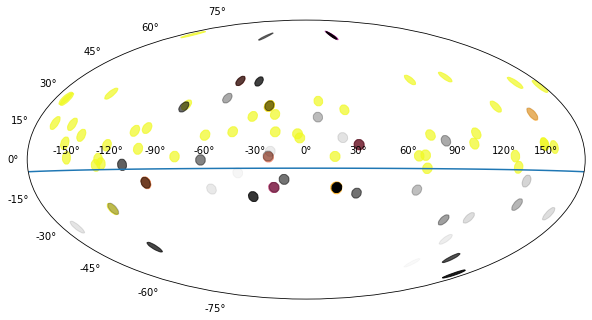

In [105]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap

fig = plt.figure()
fig.set_size_inches((10, 8))
ax = fig.add_subplot(111, projection='hammer')

for r, d, l in zip(e_ra, e_dec, lam):
    color = label_cmap.colors[int(l)]
    circle = mpatches.Circle((r-np.pi,d), 0.05, color=color, alpha=0.7)
    ax.add_patch(circle)
norm = max([1 - _/zth for _ in redshift])
for r, d, z in zip(s_ra, s_dec, redshift):
    circle = mpatches.Circle((r-np.pi,d), 0.05, color='k', alpha=(1-z/zth)/norm)
    ax.add_patch(circle)
ax.axhline(np.deg2rad(-5))

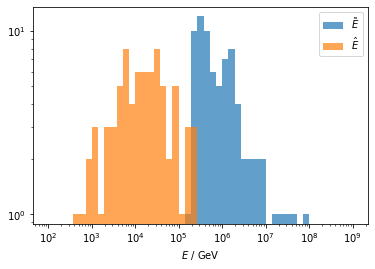

In [87]:
# Plot energies
Emin_cascades = inputs['Emin']
bins = np.logspace(np.log(Emin_cascades/1000), np.log(1E+4*Emin_cascades), base = np.e)

fig, ax = plt.subplots()
ax.hist(Esrc, bins=bins, label='$\\tilde{E}$', alpha=0.7);
ax.hist(10**Edet, bins=bins, label='$\hat{E}$', alpha=0.7);
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / GeV')
ax.legend();

In [71]:
Edet

array([4.73161943, 3.11312231, 4.18774853, 4.62398562, 5.08987531,
       4.42120134, 4.85707276, 3.14819326, 5.00274115, 4.91033172,
       5.02415274, 4.88832978, 4.42955737, 3.15365895, 3.51774776,
       3.76212577, 4.79111078, 3.44396786, 3.56265385, 4.02247685,
       3.39597908, 5.00169689, 4.09863396, 4.08087019, 3.73144326,
       3.84308927, 4.86241114, 4.27663118, 3.70515622, 3.58783035,
       2.76867129, 3.18655489, 3.16223845, 4.61964199, 3.35730022,
       4.69276706, 4.36174626, 4.00409691, 5.10004332, 3.07785209])